<a href="https://colab.research.google.com/github/seun829/DataScience/blob/main/Unit3/SeunLee_U3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the True Average Number of Google Stock (in millions) Traded in a Day


First we will import all of the required tools.

In [ ]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import preliz as pz
import pymc as pm
import arviz as az

In [ ]:
import pandas as pd

# Introduction

For this project I will be predicting the true number of Google stock that is traded everyday, taking this by the millions for cleaner data and results.


I chose this topic because volume is an important factor to consider and predicting volume can be very helpful in making decisions with stocks. I feel that ultimately, there are some hidden patterns in volume in stocks that I hope to uncover through this project.


I felt that doing this for the whole market would be not so great of an idea considering the volatility, which is why I chose to look at specifically data about Google stock.

# Prior/Likelihood

For a prior I will use a Uniform distribution to have a general sense of the situation of Google stock volume.


Based on data pulled from Robinhood it states that the 3 month average for Google Stock volume was 29.13 million (https://robinhood.com/us/en/stocks/GOOGL/) with sources like Yahoo finance saying 23.39 million (https://finance.yahoo.com/quote/GOOGL/key-statistics).

I will set the parameters to 23.39 and 29.19 as the lower and upper bound.

<Axes: >

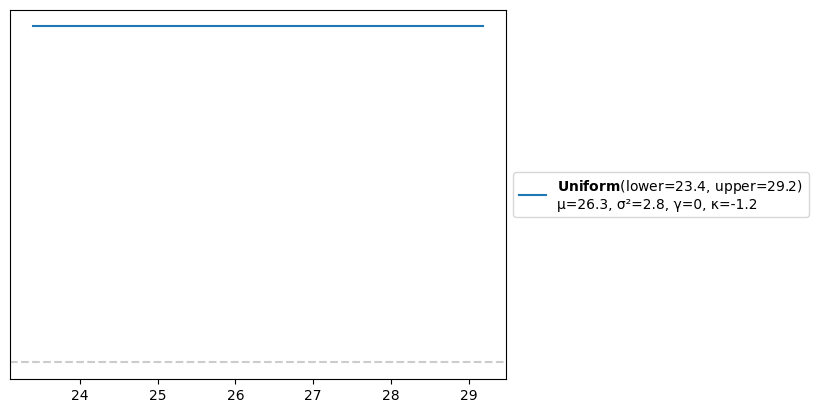

In [ ]:
pz.Uniform(23.39, 29.19).plot_pdf(moments="mvsk")

Next I will use my dataset for my likelihood.

In [ ]:
link = "https://raw.githubusercontent.com/seun829/DataScience/refs/heads/main/Google-Stock-Data.csv"
google_data = pd.read_csv(link)

In [ ]:
google_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
4853,2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
4854,2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
4855,2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400
4856,2023-12-04,131.294006,131.449997,129.399994,130.630005,130.630005,24117100


We want only the volume collumn, so we will filter that out.

In [ ]:
google_data = google_data['Volume']
google_data = google_data / 1_000_000
google_data.mean() #getting the mean for later reference

np.float64(118.91521728962533)

I will now use a HalfNormal Distribution as another prior. Solving for sigma using the formula (mean = (sqrt(2) * sigma)/sqrt(pi)) I get sigma is around 149.

<Axes: >

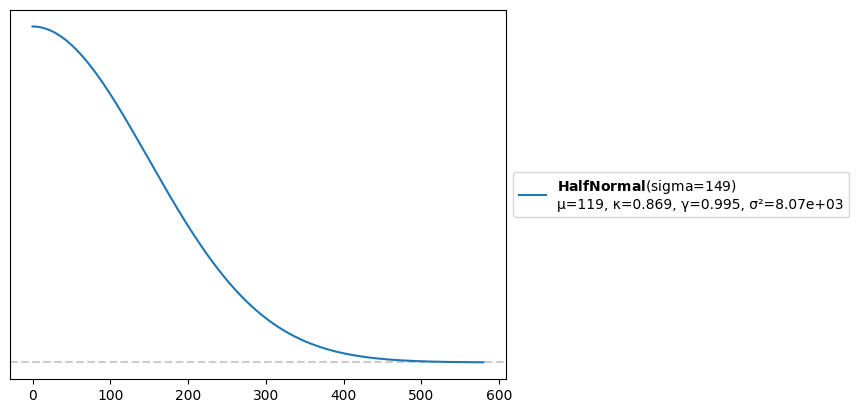

In [ ]:
pz.HalfNormal(sigma = 149).plot_pdf(moments="mksv")

In [ ]:
#N for normal
with pm.Model() as model_google_data_HN:
    μ = pm.Uniform('μ', lower=23.39, upper=29.19)

    #half of a normal dist
    σ = pm.HalfNormal('σ', sigma=149)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=google_data)
    idata_google_data_HN = pm.sample()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

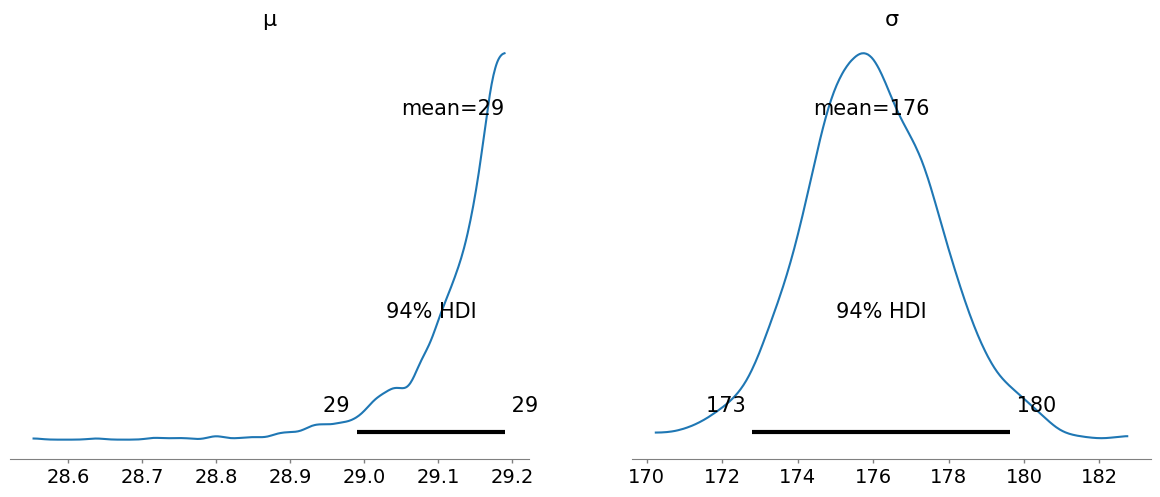

In [ ]:
az.plot_posterior(idata_google_data_HN)

Now I am going to check which pairs our model recommends.

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

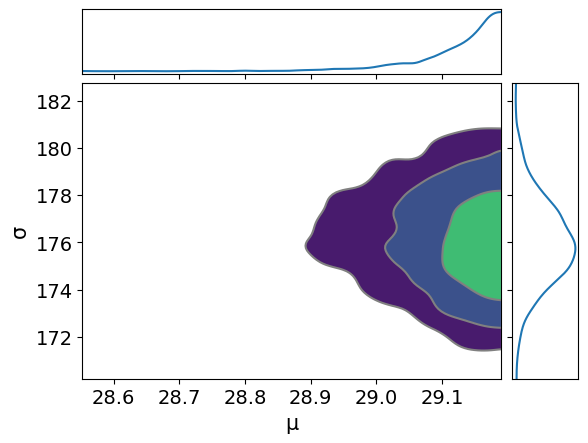

In [ ]:
az.plot_pair(idata_google_data_HN, kind='kde', marginals=True)

I will also use posterior predictive checks to truly make a practical prediction.

In [ ]:
pm.sample_posterior_predictive(idata_google_data_HN, model=model_google_data_HN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

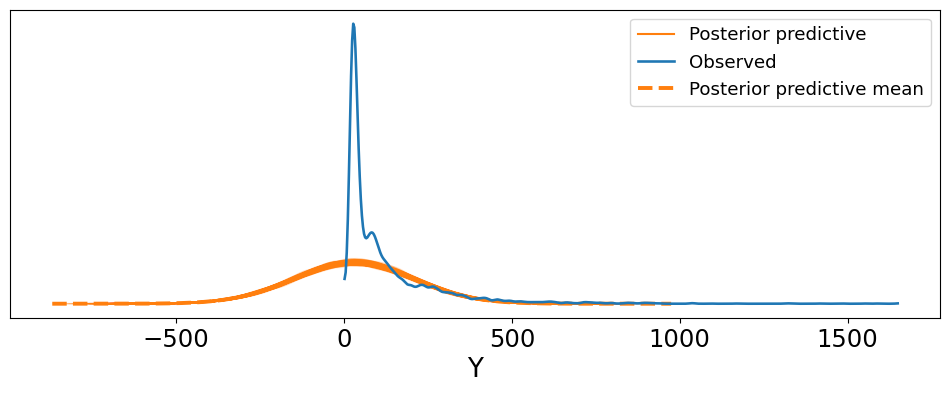

In [ ]:
az.plot_ppc(idata_google_data_HN, num_pp_samples=1000, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Conclusion

In conclusion, it seems as though my means are quite scattered. This could be due to a variety of reasons, but I now believe the main one to be that depending on the date the volume may have been staggeringly different or volatile as my dataset covers 2005 to 2023 while my other prior is based on recent trends. Therefore, trying to optimize the PPC's would not be able to solve the underlying problem of context of the data.

In the future, it would be better to account for the date ranges that I am pulling from in a clever way (like basing prior inferences more skewed towards date ranges from the dataset).

Additionally, I could base my data only on the current state in the future to mitigate these differences in volume when date is involved.